Mariana MacDonald
Week 7
Chapter 9
Exercise 9.1

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np

import random

import thinkstats2
import thinkplot

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [5]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [6]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [7]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [8]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [9]:
#here the function is running different tests 1000 times (iters),
#live is the dataframe.

def RunTests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

# 1st test is to verify the difference in mean pregnancy length using
#the variable prglnght

    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

#2nd test is to check the difference in mean birth weight using the
#variable totalwgt_lb    
    
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

# 3rd test is the correlation of mother's age and birth weight
#a new df  is created called live2, comparing the agepreg and totalwgt_lb
#variables to see if there is a correlation.

    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

# 4th test is the chi-square test of pregnancy length. 

    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [10]:
#considering a range of 7 groups, using samplerows to select a random 
#subset of rows in the data frame (live).

n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2    

9148	0.16	0.00	0.00	0.00
4574	0.40	0.01	0.00	0.00
2287	0.70	0.01	0.00	0.00
1143	0.65	0.35	0.01	0.00
571	0.57	0.04	0.12	0.31
285	0.65	0.27	0.04	0.27
142	0.76	0.22	0.49	0.80


As sample size decreases, the p-value increases.
If sample size increases, p-values tend to be smaller, if the null hypothesis is false. 

Chapter 10
Exercise 10.1

In [11]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [12]:
import numpy as np

import random

import thinkstats2
import thinkplot

In [13]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [14]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [15]:
#Estimate intercept and slope.
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

In [16]:
#Use resampling to compute sampling distributions for inter and slope.
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

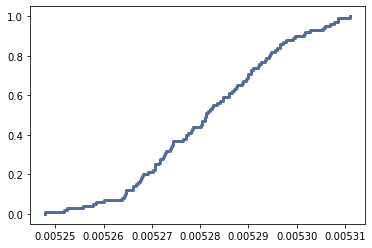

In [17]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [18]:
#Compute the 90% confidence interval of slope.
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005257836970793534, 0.005305797573522085)

In [19]:
mean = thinkstats2.Mean(slopes)
mean

0.005281607282914538

In [20]:
stderr = thinkstats2.Std(slopes)
stderr

1.4113968494708976e-05

In [21]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [22]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [23]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95705142585743 0.016092393745622404 (168.92796438893268, 168.98038814446534)


In [24]:
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [26]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(10)]
Summarize(estimates_weighted)

mean, SE, CI 170.50397289759292 0.012834567077119366 (170.4767173952586, 170.52032427898703)


In [25]:
# The estimated mean height is almost 2 cm taller 
# if we take into account the sampling weights,
# and this difference is much bigger than the sampling error.